In [1]:
import pandas as pd
import numpy as np
import re, string
import nltk
import random
import sklearn
from nltk.collocations import *
from nltk import FreqDist, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Downloaded Data and used code to convert to csv

In [1]:
######## write a function to take all the json files i want to run this and do them for all. 

headers=True
####put file name here in json and file name to be written. This one is for reviews.json

filein = 'review.json'
fileout = 'reviews.csv'
with open(filein, encoding= 'cp866') as jsonf, open (fileout, 'w') as csvf:
    for line in jsonf:
        data = json.loads(line)
         
        if headers:
            keys =[]
            for k, v in data.items():
                keys.append(k)
            writer= csv.DictWriter(csvf, fieldnames=keys)
            writer.writeheader()
            headers=False
        writer. writerow(data)

In [2]:
#### START #######

# Bringing in Review DataSet and starting to clean 

In [6]:
reviews= pd.read_csv('reviews.csv')

In [7]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [8]:
## checking to see how many reviews are classified as useful 

print (np.sum(reviews['useful'] > 0))
print (np.sum(reviews['useful'] > 1))
print (np.sum(reviews['useful'] > 2))
print (np.sum(reviews['useful'] > 3))
print (np.sum(reviews['useful'] > 4))

3115446
1684814
1015774
665966
464194


In [9]:
#checking len and shape 
reviews.shape

(6685900, 9)

In [10]:
### checking to see how many reviews fall into what catergory 

print (np.sum(reviews['stars'] == 1))
print (np.sum(reviews['stars'] == 2))
print (np.sum(reviews['stars'] == 3))
print (np.sum(reviews['stars'] == 4))
print (np.sum(reviews['stars'] == 5))

1002159
542394
739280
1468985
2933082


In [11]:
## Changed the reviews to drop columns that wont be used. 
reviews1= reviews.drop(['funny', 'cool','date'], axis=1)

In [12]:
## checking updated df 
reviews1.head(1)

,review_id,user_id,business_id,stars,useful,text
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,Total bill for this horrible service? Over $8G...


In [13]:
reviews1.isna().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
text           2
dtype: int64

In [14]:
reviews1.dropna(inplace=True)

In [15]:
reviews1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6685898 entries, 0 to 6685899
Data columns (total 6 columns):
review_id      object
user_id        object
business_id    object
stars          float64
useful         int64
text           object
dtypes: float64(1), int64(1), object(4)
memory usage: 357.1+ MB


In [16]:
reviews1.shape


(6685898, 6)

## Bringing in Business Dataset and starting to clean


In [4]:
business = pd.read_csv('business.csv')

In [5]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,NaN,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [6]:
business.shape

(192609, 14)

In [7]:
business1= business.drop(['address','postal_code','latitude','longitude','is_open','attributes','hours'],axis=1)

In [94]:
business1.head()

,index,business_id,name,city,state,stars,review_count,categories,is_restaurant
0,0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,3.0,5,"Golf, Active Life",0
1,1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",1
2,2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese",1
3,3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,Goodyear,AZ,5.0,3,"Insurance, Financial Services",0
4,4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,Charlotte,NC,4.0,4,"Plumbing, Shopping, Local Services, Home Servi...",0


In [95]:
business1.isna().sum()

index            0
business_id      0
name             0
city             0
state            0
stars            0
review_count     0
categories       0
is_restaurant    0
dtype: int64

In [10]:
business1.dropna(inplace=True)

In [11]:
business1.isna().sum()

business_id     0
name            0
city            0
state           0
stars           0
review_count    0
categories      0
dtype: int64

In [12]:
business1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192126 entries, 0 to 192608
Data columns (total 7 columns):
business_id     192126 non-null object
name            192126 non-null object
city            192126 non-null object
state           192126 non-null object
stars           192126 non-null float64
review_count    192126 non-null int64
categories      192126 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 11.7+ MB


In [13]:
business1= business1.reset_index()

In [14]:
business1.head(1)

,index,business_id,name,city,state,stars,review_count,categories
0,0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,3.0,5,"Golf, Active Life"


In [15]:
business1[business1.categories == '[]']

,index,business_id,name,city,state,stars,review_count,categories


In [29]:
business_list= list(business1['categories'])

In [30]:
type(business_list)


list

In [31]:
len(business_list)

192126

In [39]:
business2= business1

In [40]:
business2.head()

,index,business_id,name,city,state,stars,review_count,categories
0,0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,3.0,5,"Golf, Active Life"
1,1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported..."
2,2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese"
3,3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,Goodyear,AZ,5.0,3,"Insurance, Financial Services"
4,4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,Charlotte,NC,4.0,4,"Plumbing, Shopping, Local Services, Home Servi..."


In [41]:
business2['is_restaurant'] =0

In [42]:
business2.head(2)

,index,business_id,name,city,state,stars,review_count,categories,is_restaurant
0,0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,3.0,5,"Golf, Active Life",0
1,1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",0


In [43]:
business2.loc[business2['categories'].str.contains('Restaurants'), 'is_restaurant'] = 1


# for loop took to long 
# for i in range(192126):
#     if "Restaurants" in business2['categories'][i]:
#         business2.loc[business2.is_restaurant][i] = 1
#     else:
#         business2.loc[business2.is_restaurant][i] = 0 

In [44]:
business2.head(2)

,index,business_id,name,city,state,stars,review_count,categories,is_restaurant
0,0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,3.0,5,"Golf, Active Life",0
1,1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",1


In [45]:
business2[1000:1019]

,index,business_id,name,city,state,stars,review_count,categories,is_restaurant
1000,1002,YH8Bn-7pLR-SFR8MCgQj1w,Jules Cafe Patisserie,Toronto,ON,3.5,44,"Bakeries, Food, Mediterranean, French, Restaur...",1
1001,1003,RLyqeVI4a-019BRK-9IhzQ,Angelo's Cobbler Shoppe,Cleveland,OH,5.0,3,"Shoe Repair, Local Services",0
1002,1004,OY1kLAhs9I6Ix4wUmSNAfQ,Morgane Bistro & Pub,Saint-Jean-sur-Richelieu,QC,4.0,4,"Pubs, Gastropubs, Restaurants, Nightlife, Bars",1
1003,1005,4FE9FM8uvn9CV76Bxfxogw,T&T Roti Trinidad & Toronto Roti,Toronto,ON,4.0,9,"Caribbean, Restaurants",1
1004,1006,J0P152h7wimvdJ-aV0QLug,Stone Creek Coffee,Madison,WI,4.5,38,"Food, Coffee & Tea",0
1005,1007,nXL0quDqN4YYSOyYhcQByw,Holt Window Cleaning,Chandler,AZ,5.0,4,"Window Washing, Home Services, Home & Garden, ...",0
1006,1008,pvXdMR9tcQlwXcXJLllmPg,Kangaroo Express,Rock Hill,SC,4.0,3,"Automotive, Convenience Stores, Gas Stations, ...",0
1007,1009,nYvBZYg9rfqWFTYuxSVMdw,Cantina Laredo,Westlake,OH,4.0,62,"Mexican, Bars, Restaurants, Vegetarian, Nightlife",1
1008,1010,dDr4b8AKwpOiP_-JsQ93vg,The Chocolate Bar,Calgary,AB,3.0,7,"Food, Desserts",0
1009,1011,OiZsIGscvwlL_0yhWmjJtw,Pacific East,Solon,OH,3.5,11,"Food, Malaysian, Restaurants, Japanese",1


In [46]:
np.sum(business2['is_restaurant'] == 1)

59371

In [47]:
business2.loc[business2['categories'].str.contains('Food'), 'is_restaurant'] = 1

In [48]:
np.sum(business2['is_restaurant'] == 1)

74587

In [49]:
business2= business2[business2.is_restaurant == 1]

In [50]:
business2= business2.reset_index()

In [79]:
business2.head(2)

,level_0,index,business_id,name,city,state,stars,review_count,categories,is_restaurant
0,1,1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",1
1,2,2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese",1


In [45]:
business2= business2.drop(['index','categories','is_restaurant'], axis=1)

In [46]:
business2.head(2)

,level_0,business_id,name,city,state,stars,review_count
0,1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128
1,2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170


In [47]:
business2= business2.drop(['level_0'], axis=1)

In [48]:
business2.head(2)

,business_id,name,city,state,stars,review_count
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170


In [16]:
####### trying to sepearte out the catgories columns #######





In [80]:
business3=business2

In [81]:
business3[35900:35905]

,level_0,index,business_id,name,city,state,stars,review_count,categories,is_restaurant
35900,92576,92806,jG46RAFm2kWshUIZ4HoJtg,Tadka Sizzles,Phoenix,AZ,3.0,11,"Fast Food, Event Planning & Services, Indian, ...",1
35901,92579,92809,YszwELGfyPgPhjy2UJwAxQ,Later Tater,Gilbert,AZ,4.0,8,"Food, Food Trucks",1
35902,92580,92810,SbxJg9yYyIclmPDSur1FCQ,Golden Hawaiian BBQ,Chandler,AZ,3.5,134,"Hawaiian, Asian Fusion, Barbeque, Restaurants",1
35903,92582,92812,TFhZOVGcViyYZkxJ62X-dQ,CoCo,Markham,ON,3.5,29,"Juice Bars & Smoothies, Bubble Tea, Tea Rooms,...",1
35904,92583,92813,IhNASEZ3XnBHmuuVnWdIwA,Brew Tea Bar,Las Vegas,NV,5.0,1506,"Tea Rooms, Desserts, Cafes, Restaurants, Food,...",1


In [ ]:
#code to expand the categories and expand them out 

In [82]:
def expand_categories(df, cat_var, key):
    all_cats = df[cat_var].str.cat(sep=', ')
    all_cats = all_cats.replace('[', '')
    all_cats = all_cats.replace(']', '')
    all_cats = all_cats.replace("\'","")
    all_cats = all_cats.replace('"','')
    all_cats_list = all_cats.split(', ')
    unique_cats = list(set(all_cats_list))
    unique_cats.remove('Restaurants')
    unique_cats.remove('Food')
    df_cats = pd.DataFrame(index=df[key], columns=unique_cats, data=False)
    df_out = df.merge(df_cats, how='left', left_on=key, right_index=True)
    for cat in unique_cats:
        df_out[cat] = df_out[cat_var].str.contains(cat)
    return df_out 

In [83]:
restaurants_df = expand_categories(business3, 'categories', 'business_id')
restaurants_df.drop('categories', axis=1, inplace=True)

/home/mubarakb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [84]:
restaurants_df[16000:16005]

,level_0,index,business_id,name,city,state,stars,review_count,is_restaurant,Mass Media,Hawaiian,Libraries,Speech Therapists,Southern,Pet Stores,Masonry/Concrete,Eastern European,Eyebrow Services,Firewood,Sushi Bars,Wineries,Egyptian,Island Pub,Wine Bars,Family Practice,Sicilian,Officiants,Eatertainment,Hookah Bars,Computers,Fast Food,Rotisserie Chicken,Dive Bars,Teeth Whitening,Trusts,Golf Cart Rentals,Holiday Decorations,Airsoft,Transmission Repair,Furniture Reupholstery,Personal Shopping,Hospitals,Boat Dealers,Ethnic Food,Medical Spas,Oil Change Stations,Video Game Stores,Backshop,Electronics,Bar Crawl,Limos,Senegalese,Airport Shuttles,Gastropubs,Supernatural Readings,Spiritual Shop,Eyewear & Opticians,Medical Supplies,Iberian,Plus Size Fashion,Macarons,Real Estate Services,Tax Services,Knitting Supplies,Pan Asian,Foundation Repair,Electricians,Burmese,Pop-Up Restaurants,Art Classes,Udon,Skydiving,Luggage,Czech,Massage Therapy,Nicaraguan,Thai,Caterers,Wine Tours,Check Cashing/Pay-day Loans,Hobby Shops,Mongolian,Vape Shops,Fruits & Veggies,Market Stalls,Beer Tours,Golf,RV Parks,Stadiums & Arenas,Chiropractors,Shopping,Patisserie/Cake Shop,Hydrotherapy,Printing Services,Emergency Medicine,Trailer Repair,Tobacco Shops,Airport Terminals,Turkish,Tanning Beds,Summer Camps,Churches,Septic Services,Musicians,Colleges & Universities,Restaurant Supplies,Personal Chefs,Pilates,Pubs,Russian,Tickets,Architectural Tours,Signmaking,Laotian,Kitchen & Bath,Donairs,Strip Clubs,Peruvian,Hiking,General Dentistry,Donuts,University Housing,Dance Schools,Dance Wear,Fireplace Services,Pressure Washers,Campgrounds,Falafel,Fences & Gates,Roadside Assistance,Pakistani,Home Window Tinting,Persian/Iranian,Body Shops,Cardiologists,Antiques,Indian,Adult,Haunted Houses,Glass & Mirrors,Oaxacan,Watches,Irish Pub,Pharmacy,Shoe Stores,Rehabilitation Center,Day Spas,Empanadas,Real Estate Agents,Laundry Services,Afghan,Psychics,Water Suppliers,Hot Tub & Pool,Cards & Stationery,Ticket Sales,Venezuelan,Graphic Design,Halal,Screen Printing/T-Shirt Printing,Shanghainese,Scandinavian,Hotels,Comedy Clubs,Tasting Classes,Gas Stations,Car Buyers,Sleep Specialists,Tours,Landscaping,Propane,Smog Check Stations,Holistic Animal Care,Bistros,Arcades,Ophthalmologists,Health Coach,Bars,Meat Shops,Wholesalers,British,Australian,Notaries,Professional Services,Town Car Service,Doulas,Anesthesiologists,Party Equipment Rentals,Shopping Centers,Belgian,Home Cleaning,Tattoo,Mauritius,Brazilian,Midwives,Photographers,Ice Cream & Frozen Yogurt,Batting Cages,Vehicle Wraps,Courthouses,Transportation,Vietnamese,Alternative Medicine,Barbers,Bus Tours,Ethiopian,Syrian,Hair Stylists,Metal Fabricators,Coffeeshops,Breakfast & Brunch,Kombucha,Puerto Rican,Recording & Rehearsal Studios,Furniture Stores,Shaved Snow,General Festivals,Auto Parts & Supplies,Financial Services,Cupcakes,Pets,Filipino,Wedding Planning,Cosmetic Dentists,Argentine,Dry Cleaning,Race Tracks,Jewelry,Legal Services,Tanning,Poutineries,Appliances & Repair,Cardio Classes,Costumes,Contractors,Animal Physical Therapy,Wheel & Rim Repair,Mobile Phone Repair,Salvadoran,Bounce House Rentals,Event Photography,Olive Oil,Cannabis Clinics,Auto Glass Services,Head Shops,Honey,International,Butcher,Candy Stores,Skin Care,Art Supplies,Hair Extensions,Bird Shops,Mountain Biking,Game Meat,Tabletop Games,Sports Clubs,Customs Brokers,Used Bookstore,Christmas Markets,Car Share Services,Pain Management,Beauty & Spas,Pet Services,Cannabis Dispensaries,Beer,Vintage & Consignment,Delicatessen,Paintball,Austrian,Hair Salons,Bingo Halls,Vocational & Technical School,Clowns,Print Media,Singaporean,Conveyor Belt Sushi,Used Car Dealers,Weight Loss Centers,Ice Delivery,Noodles,Pet Boarding,Home & Garden,Photo Booth Rentals,Personal Injury Law,DJs,Bikes,Appliances,Animal Shelters,Visitor Centers,Siding,Home Decor,Vegan,Lounges,Convenience Stores,Internet Cafes,Flea Markets,Preschools,Soba,Opera & Ballet,Makeup Artists,Educational Services,Dermatologists,S

In [85]:
restaurants_df.shape

(74587, 886)

In [86]:
restaurants_df['state'].unique()

array(['ON', 'NC', 'AZ', 'OH', 'NV', 'PA', 'AB', 'QC', 'WI', 'IL', 'NY',
       'SC', 'NM', 'VA', 'BAS', 'NE', 'XGM', 'CA', 'WA', 'XWY', 'CON',
       'TX', 'BC', 'VT', 'AL', 'AR', 'FL', 'XGL'], dtype=object)

In [87]:
len(restaurants_df['state'].unique())

28

In [88]:
len(restaurants_df['city'].unique())

844

In [89]:
pd.set_option('display.max_columns', 900)

In [90]:
restaurants_df.head(2)

,level_0,index,business_id,name,city,state,stars,review_count,is_restaurant,Mass Media,Hawaiian,Libraries,Speech Therapists,Southern,Pet Stores,Masonry/Concrete,Eastern European,Eyebrow Services,Firewood,Sushi Bars,Wineries,Egyptian,Island Pub,Wine Bars,Family Practice,Sicilian,Officiants,Eatertainment,Hookah Bars,Computers,Fast Food,Rotisserie Chicken,Dive Bars,Teeth Whitening,Trusts,Golf Cart Rentals,Holiday Decorations,Airsoft,Transmission Repair,Furniture Reupholstery,Personal Shopping,Hospitals,Boat Dealers,Ethnic Food,Medical Spas,Oil Change Stations,Video Game Stores,Backshop,Electronics,Bar Crawl,Limos,Senegalese,Airport Shuttles,Gastropubs,Supernatural Readings,Spiritual Shop,Eyewear & Opticians,Medical Supplies,Iberian,Plus Size Fashion,Macarons,Real Estate Services,Tax Services,Knitting Supplies,Pan Asian,Foundation Repair,Electricians,Burmese,Pop-Up Restaurants,Art Classes,Udon,Skydiving,Luggage,Czech,Massage Therapy,Nicaraguan,Thai,Caterers,Wine Tours,Check Cashing/Pay-day Loans,Hobby Shops,Mongolian,Vape Shops,Fruits & Veggies,Market Stalls,Beer Tours,Golf,RV Parks,Stadiums & Arenas,Chiropractors,Shopping,Patisserie/Cake Shop,Hydrotherapy,Printing Services,Emergency Medicine,Trailer Repair,Tobacco Shops,Airport Terminals,Turkish,Tanning Beds,Summer Camps,Churches,Septic Services,Musicians,Colleges & Universities,Restaurant Supplies,Personal Chefs,Pilates,Pubs,Russian,Tickets,Architectural Tours,Signmaking,Laotian,Kitchen & Bath,Donairs,Strip Clubs,Peruvian,Hiking,General Dentistry,Donuts,University Housing,Dance Schools,Dance Wear,Fireplace Services,Pressure Washers,Campgrounds,Falafel,Fences & Gates,Roadside Assistance,Pakistani,Home Window Tinting,Persian/Iranian,Body Shops,Cardiologists,Antiques,Indian,Adult,Haunted Houses,Glass & Mirrors,Oaxacan,Watches,Irish Pub,Pharmacy,Shoe Stores,Rehabilitation Center,Day Spas,Empanadas,Real Estate Agents,Laundry Services,Afghan,Psychics,Water Suppliers,Hot Tub & Pool,Cards & Stationery,Ticket Sales,Venezuelan,Graphic Design,Halal,Screen Printing/T-Shirt Printing,Shanghainese,Scandinavian,Hotels,Comedy Clubs,Tasting Classes,Gas Stations,Car Buyers,Sleep Specialists,Tours,Landscaping,Propane,Smog Check Stations,Holistic Animal Care,Bistros,Arcades,Ophthalmologists,Health Coach,Bars,Meat Shops,Wholesalers,British,Australian,Notaries,Professional Services,Town Car Service,Doulas,Anesthesiologists,Party Equipment Rentals,Shopping Centers,Belgian,Home Cleaning,Tattoo,Mauritius,Brazilian,Midwives,Photographers,Ice Cream & Frozen Yogurt,Batting Cages,Vehicle Wraps,Courthouses,Transportation,Vietnamese,Alternative Medicine,Barbers,Bus Tours,Ethiopian,Syrian,Hair Stylists,Metal Fabricators,Coffeeshops,Breakfast & Brunch,Kombucha,Puerto Rican,Recording & Rehearsal Studios,Furniture Stores,Shaved Snow,General Festivals,Auto Parts & Supplies,Financial Services,Cupcakes,Pets,Filipino,Wedding Planning,Cosmetic Dentists,Argentine,Dry Cleaning,Race Tracks,Jewelry,Legal Services,Tanning,Poutineries,Appliances & Repair,Cardio Classes,Costumes,Contractors,Animal Physical Therapy,Wheel & Rim Repair,Mobile Phone Repair,Salvadoran,Bounce House Rentals,Event Photography,Olive Oil,Cannabis Clinics,Auto Glass Services,Head Shops,Honey,International,Butcher,Candy Stores,Skin Care,Art Supplies,Hair Extensions,Bird Shops,Mountain Biking,Game Meat,Tabletop Games,Sports Clubs,Customs Brokers,Used Bookstore,Christmas Markets,Car Share Services,Pain Management,Beauty & Spas,Pet Services,Cannabis Dispensaries,Beer,Vintage & Consignment,Delicatessen,Paintball,Austrian,Hair Salons,Bingo Halls,Vocational & Technical School,Clowns,Print Media,Singaporean,Conveyor Belt Sushi,Used Car Dealers,Weight Loss Centers,Ice Delivery,Noodles,Pet Boarding,Home & Garden,Photo Booth Rentals,Personal Injury Law,DJs,Bikes,Appliances,Animal Shelters,Visitor Centers,Siding,Home Decor,Vegan,Lounges,Convenience Stores,Internet Cafes,Flea Markets,Preschools,Soba,Opera & Ballet,Makeup Artists,Educational Services,Dermatologists,S

In [98]:
restaurants_df.shape

(74587, 786)

In [107]:
restaurants_df['Active Life'].sum()

447

In [119]:
restaurants_df.iloc[:,8:].head()

,is_restaurant,Hawaiian,Southern,Eastern European,Sushi Bars,Wineries,Egyptian,Island Pub,Wine Bars,Family Practice,Sicilian,Officiants,Eatertainment,Hookah Bars,Fast Food,Rotisserie Chicken,Dive Bars,Trusts,Golf Cart Rentals,Hospitals,Ethnic Food,Bar Crawl,Limos,Senegalese,Gastropubs,Iberian,Macarons,Pan Asian,Foundation Repair,Electricians,Burmese,Pop-Up Restaurants,Art Classes,Udon,Skydiving,Luggage,Czech,Massage Therapy,Nicaraguan,Thai,Caterers,Wine Tours,Check Cashing/Pay-day Loans,Mongolian,Fruits & Veggies,Market Stalls,Beer Tours,Golf,RV Parks,Stadiums & Arenas,Chiropractors,Shopping,Patisserie/Cake Shop,Hydrotherapy,Printing Services,Emergency Medicine,Trailer Repair,Airport Terminals,Turkish,Tanning Beds,Summer Camps,Churches,Septic Services,Musicians,Colleges & Universities,Restaurant Supplies,Personal Chefs,Pilates,Pubs,Russian,Tickets,Architectural Tours,Signmaking,Laotian,Donairs,Strip Clubs,Peruvian,Hiking,General Dentistry,Donuts,University Housing,Dance Wear,Fireplace Services,Pressure Washers,Campgrounds,Falafel,Fences & Gates,Roadside Assistance,Pakistani,Home Window Tinting,Persian/Iranian,Cardiologists,Antiques,Indian,Adult,Haunted Houses,Glass & Mirrors,Oaxacan,Watches,Irish Pub,Shoe Stores,Rehabilitation Center,Day Spas,Empanadas,Laundry Services,Afghan,Psychics,Water Suppliers,Hot Tub & Pool,Cards & Stationery,Ticket Sales,Venezuelan,Graphic Design,Halal,Screen Printing/T-Shirt Printing,Shanghainese,Scandinavian,Hotels,Comedy Clubs,Tasting Classes,Car Buyers,Sleep Specialists,Tours,Landscaping,Propane,Smog Check Stations,Holistic Animal Care,Bistros,Arcades,Ophthalmologists,Health Coach,Bars,Meat Shops,British,Australian,Notaries,Professional Services,Town Car Service,Doulas,Anesthesiologists,Shopping Centers,Belgian,Home Cleaning,Mauritius,Brazilian,Midwives,Photographers,Ice Cream & Frozen Yogurt,Batting Cages,Vehicle Wraps,Courthouses,Transportation,Vietnamese,Alternative Medicine,Barbers,Ethiopian,Syrian,Hair Stylists,Metal Fabricators,Coffeeshops,Breakfast & Brunch,Kombucha,Puerto Rican,Recording & Rehearsal Studios,Furniture Stores,Shaved Snow,General Festivals,Auto Parts & Supplies,Financial Services,Cupcakes,Pets,Filipino,Cosmetic Dentists,Argentine,Dry Cleaning,Race Tracks,Legal Services,Tanning,Poutineries,Cardio Classes,Costumes,Animal Physical Therapy,Wheel & Rim Repair,Mobile Phone Repair,Salvadoran,Bounce House Rentals,Event Photography,Olive Oil,Cannabis Clinics,Honey,International,Butcher,Candy Stores,Skin Care,Art Supplies,Hair Extensions,Bird Shops,Mountain Biking,Game Meat,Tabletop Games,Sports Clubs,Customs Brokers,Used Bookstore,Christmas Markets,Car Share Services,Pain Management,Cannabis Dispensaries,Beer,Vintage & Consignment,Delicatessen,Paintball,Austrian,Hair Salons,Bingo Halls,Vocational & Technical School,Clowns,Print Media,Singaporean,Conveyor Belt Sushi,Used Car Dealers,Ice Delivery,Noodles,Pet Boarding,Photo Booth Rentals,Personal Injury Law,DJs,Bikes,Appliances,Visitor Centers,Siding,Vegan,Lounges,Internet Cafes,Flea Markets,Preschools,Soba,Opera & Ballet,Makeup Artists,Educational Services,Dermatologists,Salad,Gelato,Massage,Armenian,Honduran,Soul Food,Beer Bar,Windshield Installation & Repair,Soccer,Boating,Sports Medicine,Heating & Air Conditioning/HVAC,Product Design,Leisure Centers,Pawn Shops,Immigration Law,Hot Pot,Boat Charters,Passport & Visa Services,Handyman,Bookkeepers,Cooking Classes,Custom Cakes,Books,Mediterranean,Windows Installation,Arabian,Vitamins & Supplements,Motorcycle Repair,Rolfing,Tires,Kosher,Kids Activities,Paint & Sip,Guamanian,Do-It-Yourself Food,Hotels & Travel,Spin Classes,Sri Lankan,Psychologists,Whiskey Bars,Dentists,Fish & Chips,Taxis,Mexican,Ethical Grocery,Service Stations,Pediatric Dentists,Fire Protection Services,Florists,Hakka,Botanical Gardens,Occupational Therapy,Keys & Locksmiths,Tonkatsu,Beer Hall,Water Heater Installation/Repair,Boat Repair,Home Services,Kebab,Active Life,Outdoor Furniture Stores,Specialty Schools,Cabinetry,Win

In [133]:
##indexing to the ctaegories and dropping categories that have less than 100 because of false categories grroupng like signmaking on some food and restaurant lablled ones


drop_uselss_cat= restaurants_df.iloc[:,8:].drop([col for col, val in restaurants_df.iloc[:,8:].sum().iteritems() if val < 100], axis=1)

In [135]:
drop_uselss_cat.shape

(74587, 162)

In [137]:
#merge on business id only with extra categories

rest_cat_bus_id = pd.concat([restaurants_df['business_id'], drop_uselss_cat], axis=1, sort=False)

In [138]:
rest_cat_bus_id.head()

,business_id,is_restaurant,Hawaiian,Southern,Sushi Bars,Wineries,Wine Bars,Hookah Bars,Fast Food,Dive Bars,Ethnic Food,Gastropubs,Thai,Caterers,Fruits & Veggies,Golf,Shopping,Patisserie/Cake Shop,Turkish,Pubs,Peruvian,Donuts,Falafel,Pakistani,Persian/Iranian,Indian,Afghan,Halal,Hotels,Tours,Bistros,Arcades,Bars,Meat Shops,British,Professional Services,Shopping Centers,Ice Cream & Frozen Yogurt,Vietnamese,Breakfast & Brunch,Cupcakes,Filipino,Poutineries,International,Butcher,Candy Stores,Beer,Delicatessen,Noodles,Vegan,Lounges,Internet Cafes,Salad,Gelato,Soul Food,Beer Bar,Hot Pot,Custom Cakes,Books,Mediterranean,Vitamins & Supplements,Kosher,Do-It-Yourself Food,Hotels & Travel,Fish & Chips,Mexican,Florists,Home Services,Active Life,Tapas/Small Plates,Greek,Buffets,Cantonese,Nightlife,Arts & Entertainment,Flowers,Flowers & Gifts,Desserts,Diners,Local Flavor,Sports Bars,Portuguese,Lebanese,Barbeque,Herbs & Spices,Italian,Specialty Food,Modern European,Dance Clubs,Farmers Market,Cafes,Wraps,Korean,Cheesesteaks,Food Stands,Juice Bars & Smoothies,Taiwanese,Health Markets,Street Vendors,Food Trucks,Chicken Wings,Bubble Tea,Seafood,Arts & Crafts,Cocktail Bars,Local Services,Imported Food,Music Venues,Karaoke,Seafood Markets,Food Delivery Services,Education,Soup,Festivals,Shaved Ice,Latin American,Chicken Shop,Bagels,Tea Rooms,Poke,Mags,Irish,Pizza,Sandwiches,Coffee Roasteries,Hot Dogs,Breweries,Organic Stores,Wine & Spirits,Caribbean,Tacos,Chinese,Cajun/Creole,Waffles,French,Ramen,Steakhouses,Dim Sum,Comfort Food,Spanish,Burgers,Bakeries,Vegetarian,Japanese,Brasseries,Chocolatiers & Shops,Tapas Bars,Venues & Event Spaces,Creperies,German,Acai Bowls,African,Cheese Shops,Casinos,Party & Event Planning,Gift Shops,International Grocery,Asian Fusion,Food Court,Middle Eastern,Delis,Tex-Mex,Coffee & Tea
0,QXAEGFB4oINsVuTFxEYKFQ,1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,gnKjwL_1w79qoiV3IC_xQQ,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1Dfx3zM-rW4n-31KeC8sJg,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [139]:
rest_cat_bus_id.drop(['is_restaurant'], axis=1, inplace=True)

In [140]:
rest_cat_bus_id.head(2)

,business_id,Hawaiian,Southern,Sushi Bars,Wineries,Wine Bars,Hookah Bars,Fast Food,Dive Bars,Ethnic Food,Gastropubs,Thai,Caterers,Fruits & Veggies,Golf,Shopping,Patisserie/Cake Shop,Turkish,Pubs,Peruvian,Donuts,Falafel,Pakistani,Persian/Iranian,Indian,Afghan,Halal,Hotels,Tours,Bistros,Arcades,Bars,Meat Shops,British,Professional Services,Shopping Centers,Ice Cream & Frozen Yogurt,Vietnamese,Breakfast & Brunch,Cupcakes,Filipino,Poutineries,International,Butcher,Candy Stores,Beer,Delicatessen,Noodles,Vegan,Lounges,Internet Cafes,Salad,Gelato,Soul Food,Beer Bar,Hot Pot,Custom Cakes,Books,Mediterranean,Vitamins & Supplements,Kosher,Do-It-Yourself Food,Hotels & Travel,Fish & Chips,Mexican,Florists,Home Services,Active Life,Tapas/Small Plates,Greek,Buffets,Cantonese,Nightlife,Arts & Entertainment,Flowers,Flowers & Gifts,Desserts,Diners,Local Flavor,Sports Bars,Portuguese,Lebanese,Barbeque,Herbs & Spices,Italian,Specialty Food,Modern European,Dance Clubs,Farmers Market,Cafes,Wraps,Korean,Cheesesteaks,Food Stands,Juice Bars & Smoothies,Taiwanese,Health Markets,Street Vendors,Food Trucks,Chicken Wings,Bubble Tea,Seafood,Arts & Crafts,Cocktail Bars,Local Services,Imported Food,Music Venues,Karaoke,Seafood Markets,Food Delivery Services,Education,Soup,Festivals,Shaved Ice,Latin American,Chicken Shop,Bagels,Tea Rooms,Poke,Mags,Irish,Pizza,Sandwiches,Coffee Roasteries,Hot Dogs,Breweries,Organic Stores,Wine & Spirits,Caribbean,Tacos,Chinese,Cajun/Creole,Waffles,French,Ramen,Steakhouses,Dim Sum,Comfort Food,Spanish,Burgers,Bakeries,Vegetarian,Japanese,Brasseries,Chocolatiers & Shops,Tapas Bars,Venues & Event Spaces,Creperies,German,Acai Bowls,African,Cheese Shops,Casinos,Party & Event Planning,Gift Shops,International Grocery,Asian Fusion,Food Court,Middle Eastern,Delis,Tex-Mex,Coffee & Tea
0,QXAEGFB4oINsVuTFxEYKFQ,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,gnKjwL_1w79qoiV3IC_xQQ,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Bringing in User Dataset and starting to clean 

In [49]:
user = pd.read_csv('user.csv')

/home/mubarakb/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,...,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,NaN,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,16,2013-10-04 00:16:10,28,8,10,NaN,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,...,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,2014-05-22 15:57:30,30,4,14,NaN,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",5,...,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,2013-10-23 07:02:50,1114,279,665,"2015,2016,2017,2018","mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",39,...,1,0,0,1,16,57,80,80,25,5


In [51]:
user.shape

(1637138, 22)

In [52]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637138 entries, 0 to 1637137
Data columns (total 22 columns):
user_id               1637138 non-null object
name                  1637135 non-null object
review_count          1637138 non-null int64
yelping_since         1637138 non-null object
useful                1637138 non-null int64
funny                 1637138 non-null int64
cool                  1637138 non-null int64
elite                 71377 non-null object
friends               1637138 non-null object
fans                  1637138 non-null int64
average_stars         1637138 non-null float64
compliment_hot        1637138 non-null int64
compliment_more       1637138 non-null int64
compliment_profile    1637138 non-null int64
compliment_cute       1637138 non-null int64
compliment_list       1637138 non-null int64
compliment_note       1637138 non-null int64
compliment_plain      1637138 non-null int64
compliment_cool       1637138 non-null int64
compliment_funny      16371

In [53]:
user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [54]:
user1= user[['user_id','review_count','average_stars']]

In [55]:
user1.head()

,user_id,review_count,average_stars
0,l6BmjZMeQD3rDxWUbiAiow,95,4.03
1,4XChL029mKr5hydo79Ljxg,33,3.63
2,bc8C_eETBWL0olvFSJJd0w,16,3.71
3,dD0gZpBctWGdWo9WlGuhlA,17,4.85
4,MM4RJAeH6yuaN8oZDSt0RA,361,4.08


In [56]:
user1.isna().sum()

user_id          0
review_count     0
average_stars    0
dtype: int64

In [57]:
user1.shape

(1637138, 3)

In [58]:
user1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637138 entries, 0 to 1637137
Data columns (total 3 columns):
user_id          1637138 non-null object
review_count     1637138 non-null int64
average_stars    1637138 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 37.5+ MB


# Create SQLlite Tables in memory 

In [2]:
from sqlalchemy import create_engine

In [3]:
engine = create_engine('sqlite:///reviews.db', echo=False)

### USER1 SQL Table/   Table Name= 'Users'

In [62]:
user1.to_sql('users', con=engine)

ValueError: Table 'users' already exists.

In [ ]:
engine.execute("SELECT * FROM users").fetchall()

### Business2 SQL Table/  Table Name= 'business'

In [4]:
business2.to_sql('business', con=engine)

NameError: name 'business2' is not defined

In [5]:
engine.execute("SELECT * FROM business").fetchall()

NameError: name 'engine' is not defined

### Create categories business table that have bus id and categories/ Table name='categories'

In [145]:
rest_cat_bus_id.to_sql('categories', con=engine)

In [146]:
engine.execute("SELECT * FROM categories").fetchone()

(0, 'QXAEGFB4oINsVuTFxEYKFQ', 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

### Reviews1 SQL Table/ Table Name= 'reviews'

In [ ]:
reviews1.to_sql('reviews', con=engine)

In [ ]:
engine.execute("SELECT * FROM reviews").fetchone()

In [70]:
engine.execute("SELECT stars FROM reviews").fetchone()

(1.0,)

In [ ]:
# 

### Query Sql table to give me only restaurant reviews. 


In [5]:
#got just the reviews
rest_reviews= engine.execute('SELECT text FROM reviews INNER JOIN business ON reviews.business_id=business.business_id').fetchall()

In [6]:
len(rest_reviews)

4580299

In [7]:
#got the reviews and ratings to match up 
rest_reviews_rating= engine.execute('SELECT reviews.stars, text FROM reviews INNER JOIN business ON reviews.business_id=business.business_id').fetchall()

In [8]:
len(rest_reviews_rating)

4580299

In [9]:
rest_reviews_rating[345]

(4.0, "I recently visited Pieology for the first time with friends recently and was really pleased with the selection and taste of the pies. For a set price ... (279 characters truncated) ...  and will return in the future.  Staff is friendly and efficient. It was a relatively quiet late afternoon so the wait was negligible.  Check it out.")

In [10]:
#GET reviews with only 1 stars and 2 and 3 and 4 and 5 seperatly 

In [4]:
one_star_reviews= engine.execute('SELECT reviews.stars, text FROM reviews INNER JOIN business ON reviews.business_id=business.business_id WHERE reviews.stars= 1.0').fetchall()

In [5]:
one_star_reviews[0:2]

[(1.0, "This place has gone down hill.  Clearly they have cut back on staff and food quality\n\nMany of the reviews were written before the menu changed.  I' ... (82 characters truncated) ...  slow & my salad, which was $15, was as bad as it gets.\n\nIt's just not worth spending the money on this place when there are so many other options."),
 (1.0, "Walked in around 4 on a Friday afternoon, we sat at a table just off the bar and walked out after 5 min or so. Don't even think they realized we walk ... (136 characters truncated) ... out. Oh well, the location they are at has been about 5 different things over the past several years, so they will just be added to the list. SMDH!!!")]

In [6]:
len(one_star_reviews)

544139

In [7]:
two_star_reviews= engine.execute('SELECT reviews.stars, text FROM reviews INNER JOIN business ON reviews.business_id=business.business_id WHERE reviews.stars= 2.0').fetchall()

In [8]:
two_star_reviews[0:2]

[(2.0, 'I was really looking forward to visiting after having some of their beers. The "Man O\'War" quickly became my favorite DIPA; the Rusulka Vanilla Stou ... (1136 characters truncated) ... ast & cheese was good, but by the time we were able to dig into their heartiest offering of food, saltines and butter may have been equally pleasing.'),
 (2.0, 'Went here last weekend and was pretty disappointed. They did not have one thing that was pictured and recommended on yelp as being good. We started o ... (517 characters truncated) ... name attached to this restaurant and going on such an empty stomach we had such high hopes. The service was great which is why i gave it three stars.')]

In [9]:
len(two_star_reviews)

420637

In [10]:
three_star_reviews= engine.execute('SELECT reviews.stars, text FROM reviews INNER JOIN business ON reviews.business_id=business.business_id WHERE reviews.stars= 3.0').fetchall()

In [11]:
three_star_reviews[0:2]

[(3.0, "Tracy dessert had a big name in Hong Kong and the one in First Markham place has been here for many years now! \n\nCame in for some Chinese dessert,  ... (984 characters truncated) ... f tables they had were just perfect because no one really waited for seats for a long time, but the tables kept filling up once a table was finished."),
 (3.0, 'I love chinese food and I love mexican food. What can go wrong? A couple of things. First things first, this place is more of a "rice bowl" kind of p ... (1739 characters truncated) ... g and throwing molotov cocktails inside. I used the bathroom like 5 times. I don\'t recommend eating this place if you have a lot to do the next day.')]

In [12]:
len(three_star_reviews)

604359

In [13]:
four_star_reviews= engine.execute('SELECT reviews.stars, text FROM reviews INNER JOIN business ON reviews.business_id=business.business_id WHERE reviews.stars= 4.0').fetchall()

In [14]:
four_star_reviews[0:2]

[(4.0, 'I\'ll be the first to admit that I was not excited about going to La Tavolta. Being a food snob, when a group of friends suggested we go for dinner I ... (1266 characters truncated) ... on\'t go with a date unless you\'re fighting and don\'t feel like hearing anything they have to say.  Ask to sit in the side room if it\'s available.'),
 (4.0, 'Like walking back in time, every Saturday morning my sister and I was in a bowling league and after we were done, we\'d spend a few quarters playing  ... (362 characters truncated) ...  80\'s theme.  There is even a Ms pac man!  It was fun to spend an afternoon playing the machines and remembering all the fun of my early teen years.')]

In [15]:
len(four_star_reviews)

1191087

In [16]:
five_star_reviews= engine.execute('SELECT reviews.stars, text FROM reviews INNER JOIN business ON reviews.business_id=business.business_id WHERE reviews.stars= 5.0').fetchall()

In [17]:
five_star_reviews[0:2]

[(5.0, "Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and  ... (115 characters truncated) ...  were pretty good.\n\nThe Server, Dawn, was friendly and accommodating. Very happy with her.\n\nIn summation, a great pub experience. Would go again!"),
 (5.0, "You can't really find anything wrong with this place, the pastas and pizzas are both amazing and high quality, the price is very reasonable, the owne ... (107 characters truncated) ... ecause it's downtown there are lots of options around but that's not always the case as there is also a lot of poor quality food in downtown as well.")]

In [18]:
len(five_star_reviews)

1820077

In [19]:
## Taking a 1-5 star random of 200,000

In [20]:
rand_items_one_star = random.sample(one_star_reviews, 40000)

In [21]:
rand_items_two_star = random.sample(two_star_reviews, 40000)

In [22]:
rand_items_three_star = random.sample(three_star_reviews, 40000)

In [23]:
rand_items_four_star = random.sample(four_star_reviews, 40000)

In [24]:
rand_items_five_star = random.sample(five_star_reviews, 40000)

In [25]:
#function to make into a list. Could have done many other ways
rand_list=[]
def combine(list):
    for i in list:
        rand_list.append(i)
    

In [26]:
combine(rand_items_one_star)

In [27]:
combine(rand_items_two_star)

In [28]:
combine(rand_items_three_star)

In [29]:
combine(rand_items_four_star)

In [30]:
combine(rand_items_five_star)

In [31]:
len(rand_list)

200000

In [32]:
# Making a df with the random downsampled 

In [33]:
ds_df= pd.DataFrame(rand_list, columns=['rating', 'review'])

In [34]:
ds_df.head()

,rating,review
0,1.0,I'm a foodie. Please trust me. I came here bec...
1,1.0,"My friend ordered chicken nuggets, and two of ..."
2,1.0,"Dirty Taps, Watertered Down Coors Lite, flat P..."
3,1.0,I really wanted to like this place but was not...
4,1.0,When you witness a server change his/her habit...


In [35]:
ds_df.shape

(200000, 2)

In [36]:
df_df1= ds_df

In [37]:
#counting words in each review
df_df1['count_rev'] = [len(x.split()) for x in ds_df.review]

In [38]:
df_df1.head()

,rating,review,count_rev
0,1.0,I'm a foodie. Please trust me. I came here bec...,164
1,1.0,"My friend ordered chicken nuggets, and two of ...",118
2,1.0,"Dirty Taps, Watertered Down Coors Lite, flat P...",130
3,1.0,I really wanted to like this place but was not...,95
4,1.0,When you witness a server change his/her habit...,76


In [39]:
#summing total words
df_df1['count_rev'].sum()

23446187

In [40]:
df_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
rating       200000 non-null float64
review       200000 non-null object
count_rev    200000 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.6+ MB


# NLTK

In [41]:
#Creating regex pattern to parse the each overview
from nltk.stem.snowball import SnowballStemmer
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

#Stemming words using SnowballStemmer
stemmer = SnowballStemmer("english")

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#Creating unique list of available stopwords in the NLTK corpus
from nltk.corpus import stopwords
# this line below opened up the dowloader for me to go in download this specific stopwords 
# nltk.download()
stop_words = set(stopwords.words('english'))

In [42]:
giant_string = []
all_words = []
for review in df_df1.review: 
    cleaned = nltk.regexp_tokenize(str(review), pattern)
    tokens = [i.lower() for i in cleaned]
    tokens_stopped = [w for w in tokens if not w in stop_words]
    meta_stemmed = [stemmer.stem(word) for word in tokens_stopped]
    string = ' '.join(meta_stemmed)
    giant_string.append(string)
    [all_words.append(w) for w in meta_stemmed]

In [43]:
len(all_words)

11780101

In [44]:
giant_string[0]

"i'm foodi pleas trust came review blown away mani peopl said good food guy place good food understand place good go eat especi place expens expect spectacular food someth can't cook home gross got ceasar salad dress pure runni mayonnais tast filet mignon cook perfect guy meat meat buy costco i'm joke steak sear anyth cook look nuke lobster mac chees swear tast creami water cream get tast chees disappoint food trust go somewher els bueno"

In [45]:
all_words_fd = nltk.FreqDist(all_words)

In [46]:
all_words_fd

FreqDist({'food': 158158, 'place': 127471, 'good': 125688, 'order': 118757, 'like': 95970, 'time': 90073, 'servic': 85209, 'go': 82174, 'get': 81326, 'one': 76249, ...})

In [51]:
reviews_nouns=[]
pos=nltk.pos_tag(all_words_fd)
leng = len(pos)
for x in range(0,leng):
    if(pos[x][1]=="NN" or pos[x][1]=='VBP' or pos[x][1]=='VB'):
        reviews_nouns.append(pos[x][0])

In [71]:
from PIL import Image
from os import path
import os
from wordcloud import WordCloud, STOPWORDS
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

    

pizza_mask = np.array(Image.open(path.join(d, "pizza_PNG44045.png")))
all_words_for_all = nltk.FreqDist(reviews_nouns)
top_200_five=all_words_for_all.most_common(200)
dictOfWords_five = dict(top_200_five)
dictOfWords_five.pop("character", None)



def word_cloud(text):
    wordcloud = WordCloud(max_words=100, mask= pizza_mask,background_color="white"
                          ).generate_from_frequencies(text)
    # Open a plot of the generated image.
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

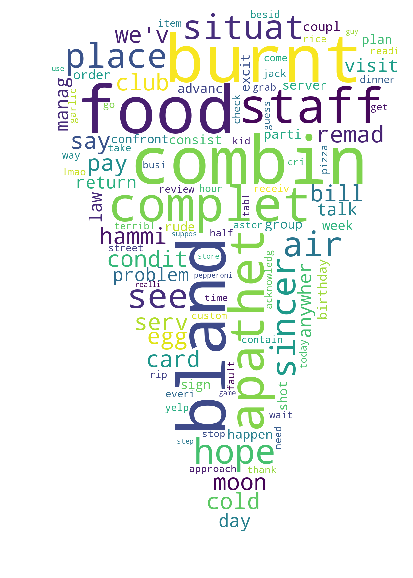

In [72]:
plt.figure(figsize=(15,10))
word_cloud(dictOfWords_five)

In [ ]:
# So changing the order here and split the test and train data before we go into the vectorization process.

In [47]:
from sklearn.model_selection import train_test_split
X = giant_string
targets= df_df1['rating']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2)

In [49]:
# tfidf on features
#in this second case we are now vectorizing after splitting the data instead of vectorizing before splitting.  

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [82]:
tfidf = TfidfVectorizer(max_features=5000)
x_train = tfidf.fit_transform(X_train)
x_test= tfidf.transform(X_test)
x_train_features_tfidf = pd.DataFrame(x_train.toarray(), columns=tfidf.get_feature_names())
x_test_features_tfidf = pd.DataFrame(x_test.toarray(), columns=tfidf.get_feature_names())

In [83]:
x_train_features_tfidf.shape

(160000, 5000)

In [84]:
x_train_features_tfidf.head()

,abil,abl,abrupt,absent,absolut,absorb,absurd,abund,abus,abysm,...,yum,yummi,yup,yuzu,zen,zero,zipp,zombi,zone,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
x_test_features_tfidf.head()

,abil,abl,abrupt,absent,absolut,absorb,absurd,abund,abus,abysm,...,yum,yummi,yup,yuzu,zen,zero,zipp,zombi,zone,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### hasing vectorizer below is like a count vectorizer. 

In [56]:
# from sklearn.feature_extraction.text import HashingVectorizer


In [57]:
# vectorizer = HashingVectorizer(n_features=5000)
# v= vectorizer.fit_transform(giant_string)
# features_hashing= pd.DataFrame(v.toarray(), columns= v.get_feature_names())


In [58]:


#the 5 lines below are using a count_vecotrizer. 


# bow_transformer = CountVectorizer().fit(giant_string)

In [59]:
# len(bow_transformer.vocabulary_)

In [60]:
# bow_25 = bow_transformer.transform([giant_string[25]])

In [61]:
# review25= df_df1['review'][25]

In [62]:
# bow_25 = bow_transformer.transform([review25])

In [63]:
# bow_25

## Model Running


In [86]:
from sklearn import linear_model

In [87]:
lm = linear_model.LinearRegression()
model = lm.fit(x_train,y_train)

In [88]:
from sklearn.metrics import mean_squared_error
yhat = model.predict(x_test)

RMSE = np.sqrt(mean_squared_error(y_test, yhat))
z_score = RMSE/np.std(y_test)
R_squared = model.score(x_test, y_test)
print("RMSE = {}, z_score = {}, R_squared = {}".format(RMSE, z_score, R_squared))

RMSE = 0.8264076717655179, z_score = 0.58257136134617, R_squared = 0.6606106089392701


In [89]:
#pickle the linreg model for rating. named it log_reg_rating but its lin_reg_rating 
import pickle
pickling_on = open("log_reg_rating","wb")
pickle.dump(model, pickling_on)
pickling_on.close()


In [90]:
pickle_off = open("log_reg_rating","rb")
lin_reg_rating = pickle.load(pickle_off)


In [ ]:
#second model for running

In [ ]:

from sklearn.svm import SVR
svr_lin = SVR(kernel='linear', verbose=10)
rat_svr = svr_lin.fit(x_train, y_train)

[LibSVM]

In [ ]:
#model grid search with pipeline



In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe_rf = Pipeline([('tf_idf_vectorizer',TfidfVectorizer()),
                   ('rf', RandomForestRegressor(n_jobs=-1))])

parameters = {'tf_idf_vectorizer__ngram_range': [(1,1),(1,2)],
              'tf_idf_vectorizer__max_features': [1000,2000,5000],
              'rf__n_estimators':[10,20,50,100],
             'rf__max_features':['auto',5,20]}

model_grid = GridSearchCV(pipe_rf,parameters,n_jobs=-1, verbose=10)

In [52]:
#passing in X_train because this is before we vecotrized earlier for the logreg. this will do it for us. 
model_grid.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/home/mubarakb/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 151.0min
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed: 320.1min
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed: 457.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 526.2min
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed: 564.4min
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed: 598.8min
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed: 638.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 668.2min
[Parall

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tf_idf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smoo...ors='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tf_idf_vectorizer__ngram_range': [(1, 1), (1, 2)], 'tf_idf_vectorizer__max_features': [1000, 2000, 5000], 'rf__n_estimators': [10, 20, 50, 100], 'rf__max_features': ['auto', 5, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [ ]:
import pickle
pickling_on_grid_rating = open("grid","wb")
pickle.dump(model, pickling_on)
pickling_on.close()

In [ ]:
###### testing code dont know how it works #####

In [212]:
rev1 = input('')

In [71]:





for overview in [rev1]: 
    rev_string = []
    cleaned = nltk.regexp_tokenize(str(overview), pattern)
    tokens = [i.lower() for i in cleaned]
    tokens_stopped = [w for w in tokens if not w in stop_words]
    meta_stemmed = [stemmer.stem(word) for word in tokens_stopped]
    string = ' '.join(meta_stemmed)
    rev_string.append(string)
tt = tfidf.transform(rev_string)


print(rev1)
print('')
rev_pred = lin_reg_rating.predict(tt)
for i in rev_pred:
    if i < 1.5:
        print ('1 Star')
    else:
        if i < 2.5:
            print ('2 star')
        else:
            if i < 3.5:
                print ('3 star')
            else:
                if i < 4.5:
                    print ('4 stars')
                else:
                    print ('5 stars')



fuck uou

2 star


In [72]:
rev_pred

array([2.37453486])

In [221]:
from tpot import TPOTRegressor
from tpot.config import regressor_config_sparse

In [224]:
pipeline_optimizer = TPOTRegressor(config_dict=regressor_config_sparse, verbosity=3,periodic_checkpoint_folder='checkpoint',generations=10, population_size=10)



In [225]:
pipeline_optimizer.fit(x_train, y_train)
# pipeline_optimizer.export('best_pipe.py')

11 operators have been imported by TPOT.


Skipped pipeline #5 due to time out. Continuing to the next pipeline.
Skipped pipeline #7 due to time out. Continuing to the next pipeline.
Skipped pipeline #9 due to time out. Continuing to the next pipeline.
Skipped pipeline #11 due to time out. Continuing to the next pipeline.
Skipped pipeline #14 due to time out. Continuing to the next pipeline.


RuntimeError: There was an error in the TPOT optimization process. This could be because the data was not formatted properly, or because data for a regression problem was provided to the TPOTClassifier object. Please make sure you passed the data to TPOT correctly.

# USEFULNESS 

In [5]:
#### Starting  SQl   ##### SQL QUERY for usefulness######

In [4]:
Useful = engine.execute('SELECT reviews.stars AS review_stars, reviews.useful AS reviews_useful, reviews.text AS review_text, users.review_count AS user_rev_count,business.stars AS bus_avg_rating From reviews INNER JOIN business ON business.business_id = reviews.business_id INNER JOIN users ON users.user_id = reviews.user_id')
#could write straight to pd
# Useful= pd.read_sql("SQLQuery", engine)


In [5]:
use_df= pd.DataFrame(Useful, columns=['review_stars','useful_rev','review_text','user_rev_count','bus_stars'])

In [6]:
use_df.head(5)

,review_stars,useful_rev,review_text,user_rev_count,bus_stars
0,5.0,0,Went in for a lunch. Steak sandwich was delici...,4,3.0
1,4.0,0,I'll be the first to admit that I was not exci...,1,3.5
2,3.0,5,Tracy dessert had a big name in Hong Kong and ...,600,3.5
3,1.0,3,This place has gone down hill. Clearly they h...,88,2.5
4,2.0,1,I was really looking forward to visiting after...,13,4.0


In [7]:
use_df.shape

(4580299, 5)

In [8]:
usefuldf= use_df

In [9]:
usefuldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4580299 entries, 0 to 4580298
Data columns (total 5 columns):
review_stars      float64
useful_rev        int64
review_text       object
user_rev_count    int64
bus_stars         float64
dtypes: float64(2), int64(2), object(1)
memory usage: 174.7+ MB


In [10]:
use_df = usefuldf[usefuldf.useful_rev >= 2]

In [11]:
use_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009932 entries, 2 to 4580298
Data columns (total 5 columns):
review_stars      1009932 non-null float64
useful_rev        1009932 non-null int64
review_text       1009932 non-null object
user_rev_count    1009932 non-null int64
bus_stars         1009932 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 46.2+ MB


In [12]:
use_df.head()

,review_stars,useful_rev,review_text,user_rev_count,bus_stars
2,3.0,5,Tracy dessert had a big name in Hong Kong and ...,600,3.5
3,1.0,3,This place has gone down hill. Clearly they h...,88,2.5
15,5.0,9,If you are looking for the best pierogies in P...,776,4.5
28,1.0,6,Met a friend for dinner there tonight. The ser...,16,3.5
30,3.0,2,One day after I satisfy my frozen yogurt cravi...,444,4.0


In [13]:
use_df.shape

(1009932, 5)

In [14]:
use_df1= use_df.sample(n=40000)

In [15]:
use_df1.shape

(40000, 5)

In [16]:
non_useful_df= usefuldf[usefuldf.useful_rev == 0]

In [17]:
non_useful_df.head()

,review_stars,useful_rev,review_text,user_rev_count,bus_stars
0,5.0,0,Went in for a lunch. Steak sandwich was delici...,4,3.0
1,4.0,0,I'll be the first to admit that I was not exci...,1,3.5
5,4.0,0,"Like walking back in time, every Saturday morn...",866,4.5
6,1.0,0,"Walked in around 4 on a Friday afternoon, we s...",2,3.5
7,4.0,0,Wow. So surprised at the one and two star revi...,12,2.0


In [18]:
non_useful_df.shape


(2579691, 5)

In [19]:
non_useful_df1= non_useful_df.sample(n=40000)

In [20]:
non_useful_df1.shape

(40000, 5)

In [21]:
# use_and_non_df= use_df[use_df.useful_rev == 0 & use_df.useful_rev>= 2]

In [22]:
#merge useful 1 and non useful df 1 we downsampled both for computational purposes
use_and_non_df= pd.concat([use_df1, non_useful_df1])


In [23]:
use_and_non_df.shape

(80000, 5)

In [24]:
use_and_non_df.shape

(80000, 5)

In [25]:
#set empty column to binarize useful into 0 or 1 
use_and_non_df['useful']  = 0

In [26]:
#if useful is over 0 then label 1 if not it keeps the same 
use_and_non_df.loc[use_and_non_df['useful_rev'] > 0 , 'useful'] = 1

In [27]:
#spelled revieiew text wrong so if error pops up or there is a change look here 
#this is counting text and in a review 
use_and_non_df['count_rev'] = [len(x.split()) for x in use_and_non_df.review_text]

In [28]:
# create category for difference between user rating and business stars 
use_and_non_df['rev_bus_rat_diff'] =  (use_and_non_df['review_stars']-use_and_non_df['bus_stars']).abs()

In [29]:
use_and_non_df= use_and_non_df.reset_index()

In [30]:
use_and_non_df.head()

,index,review_stars,useful_rev,review_text,user_rev_count,bus_stars,useful,count_rev,rev_bus_rat_diff
0,1666356,4.0,4,I had the pleasure of dining at Gates & Brovi....,333,4.0,1,169,0.0
1,2124677,3.0,2,"I dunno, I don't get the hype with these place...",162,4.5,1,139,1.5
2,247359,4.0,2,This place is awesome. They have every candy y...,454,4.0,1,89,0.0
3,3930534,4.0,2,Had a craving or a peanut buster parfait. Wow ...,62,2.0,1,25,2.0
4,684532,3.0,2,Good service and comfortable inside on a cold ...,169,4.0,1,48,1.0


In [31]:
use_and_non_df1= use_and_non_df.drop(['index','review_stars','useful_rev','bus_stars'], axis=1)

In [32]:
use_and_non_df1.tail(2)

,review_text,user_rev_count,useful,count_rev,rev_bus_rat_diff
79998,This has become our Wednesday evening treat. T...,7,0,48,0.0
79999,This place is a treasure and sometimes get a c...,10,0,52,1.5


In [33]:
use_and_non_df1.shape

(80000, 5)

In [34]:
use_and_non_df1.isna().sum()

review_text         0
user_rev_count      0
useful              0
count_rev           0
rev_bus_rat_diff    0
dtype: int64

In [35]:
### so i have the data like i want and now i want to vectorize text and add it back to the df so some of the same 
#     code might be used before 


## use_and_non_df1 is the one being used 

In [36]:
from nltk.stem.snowball import SnowballStemmer
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

#Stemming words using SnowballStemmer
stemmer = SnowballStemmer("english")

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#Creating unique list of available stopwords in the NLTK corpus
from nltk.corpus import stopwords
# this line below opened up the dowloader for me to go in download this specific stopwords 
# nltk.download()
stop_words = set(stopwords.words('english'))

In [37]:
useful_giant_string = []
useful_all_words = []
for review in use_and_non_df1.review_text: 
    cleaned = nltk.regexp_tokenize(str(review), pattern)
    tokens = [i.lower() for i in cleaned]
    tokens_stopped = [w for w in tokens if not w in stop_words]
    meta_stemmed = [stemmer.stem(word) for word in tokens_stopped]
    string = ' '.join(meta_stemmed)
    useful_giant_string.append(string)
    [useful_all_words.append(w) for w in meta_stemmed]

In [38]:
## next steps are to put this data back together and then test train split and then tfidf the columns get 5000 
## and then put back in the dataframe and scale it.
len(useful_giant_string)

80000

In [39]:
use_and_non_df1['tok_text']= useful_giant_string

In [40]:
use_and_non_df1.drop(['review_text'], axis=1, inplace=True)     

In [41]:
use_and_non_df1.head(2)

,user_rev_count,useful,count_rev,rev_bus_rat_diff,tok_text
0,333,1,169,0.0,pleasur dine gate brovi celebr birthday mother...
1,162,1,139,1.5,dunno get hype place like buffet buffet almost...


In [42]:
use_and_non_df1.isna().sum()


user_rev_count      0
useful              0
count_rev           0
rev_bus_rat_diff    0
tok_text            0
dtype: int64

In [43]:
#cut this into a better chunk of samples 

In [44]:
#so im splitting the test and train data 
# i am also dropping user rev count becuase of model training with it, seemed like it wasnt an important feature
from sklearn.model_selection import train_test_split

X1= use_and_non_df1.drop(['useful'], axis=1)
y1= use_and_non_df1['useful']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)





# # Build Models
# # Logistic Regression
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)

# print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
# print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [45]:
X_test1.shape

(16000, 4)

In [46]:
X_train1.head(2)

,user_rev_count,count_rev,rev_bus_rat_diff,tok_text
6113,9,167,2.0,place kind old school famili type burger joint...
42243,1,66,0.5,favorit tai restaur az sister went flippin awe...


In [47]:
#now i am vectorizing the text data 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_useful = TfidfVectorizer(max_features=5000)
x_train1 = tfidf_useful.fit_transform(X_train1.tok_text)
x_test1= tfidf_useful.transform(X_test1.tok_text)
x_train1_features_tfidf = pd.DataFrame(x_train1.toarray(), columns=tfidf_useful.get_feature_names())
x_test1_features_tfidf = pd.DataFrame(x_test1.toarray(), columns=tfidf_useful.get_feature_names())

In [48]:
x_train1_features_tfidf.head(2)


,abil,abl,absolut,absorb,absurd,abund,ac,acai,accent,accept,...,yum,yummi,yup,yuzu,zero,zesti,zing,zipp,zone,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
## now take these merge them back with the training ones

In [50]:
#had to match the index because the tfidf made new indexes and joining thme would be a problem. so for this and test
x_train1_features_tfidf.index = X_train1.index

In [51]:
X_train12 = X_train1.join(x_train1_features_tfidf)



In [52]:
x_test1_features_tfidf.index = X_test1.index
X_test12= X_test1.join(x_test1_features_tfidf)

In [53]:
X_test12.head(2)

,user_rev_count,count_rev,rev_bus_rat_diff,tok_text,abil,abl,absolut,absorb,absurd,abund,...,yum,yummi,yup,yuzu,zero,zesti,zing,zipp,zone,zucchini
33565,18,134,2.0,daughter sisrer nephew mood italian food decid...,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.174962,0.0,0.0,0.0,0.0,0.0
25681,5,417,1.0,suck give great place review go okay caf rio g...,0.0,0.0,0.057044,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [54]:
X_train12.head()

,user_rev_count,count_rev,rev_bus_rat_diff,tok_text,abil,abl,absolut,absorb,absurd,abund,...,yum,yummi,yup,yuzu,zero,zesti,zing,zipp,zone,zucchini
6113,9,167,2.0,place kind old school famili type burger joint...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42243,1,66,0.5,favorit tai restaur az sister went flippin awe...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47981,92,80,0.0,yeah pretti bad wast starv death load spaghett...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25599,75,286,1.5,problem happen travel brampton regular basi de...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39196,120,630,3.0,dinner upset stomach thank almost cold dinner ...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
X_train12.drop(['tok_text'], axis=1, inplace=True)
X_test12.drop(['tok_text'],axis=1, inplace=True)

In [56]:
X_train12.head(2)

,user_rev_count,count_rev,rev_bus_rat_diff,abil,abl,absolut,absorb,absurd,abund,ac,...,yum,yummi,yup,yuzu,zero,zesti,zing,zipp,zone,zucchini
6113,9,167,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42243,1,66,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train13 = scaler.fit_transform(X_train12)
X_test13 = scaler.transform(X_test12)

/home/mubarakb/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [58]:
X_train13

array([[0.00064573, 0.16733871, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06552419, 0.125     , ..., 0.        , 0.        ,
        0.        ],
       [0.00734523, 0.0796371 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01017031, 0.17137097, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00161434, 0.12701613, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00613447, 0.38608871, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [59]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train13, y_train1)

/home/mubarakb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [60]:
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train13, y_train1)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test13, y_test1)))

Accuracy of Logistic regression classifier on training set: 0.75
Accuracy of Logistic regression classifier on test set: 0.71


In [61]:
ypred= logreg.predict(X_test13)

In [149]:
#code for printing confusion matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Lable')
    plt.xlabel('Predicted Label')

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      7922
           1       0.71      0.65      0.68      8078

   micro avg       0.69      0.69      0.69     16000
   macro avg       0.69      0.69      0.69     16000
weighted avg       0.69      0.69      0.69     16000

Confusion matrix, without normalization
[[5810 2112]
 [2823 5255]]


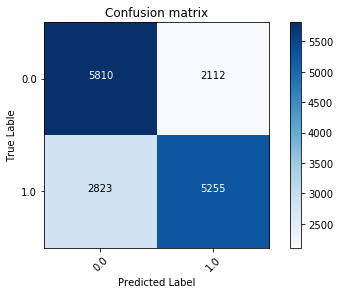

In [150]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test1, ypred))
cm = confusion_matrix(y_test1, ypred)
plot_confusion_matrix(cm, [0.0, 1.0])

In [151]:
# just getting the features to see with the coefficents. X_train12 is the last time the data was a full df 
my_features = X_train12.columns

In [152]:
#### got the least important features
my_features[np.argsort(logreg.coef_)]

Index([['walkway', 'boulevard', 'discuss', 'jeff', 'joey', 'marbl', 'anniversari', 'francisco', 'hub', 'nervous', 'breez', 'couldnt', 'foster', 'oxtail', 'einstein', 'plastic', 'ear', 'solo', 'chocolat', 'noda', 'basebal', 'nathan', 'button', 'uncl', 'concert', 'shortcak', 'trivia', 'text', 'tan', 'ambienc', 'bonn', 'je', 'licens', 'unhappi', 'identifi', 'banquet', 'unusu', 'burn', 'canada', 'atop', 'drank', 'slam', 'project', 'ness', 'essenc', 'lump', 'cashew', 'scan', 'corpor', 'boom', 'rapid', 'hispan', 'fallen', 'memor', 'ashley', 'jersey', 'atm', 'saffron', 'achiev', 'track', 'si', 'gratin', 'steve', 'scrape', 'omelett', 'virtual', 'estim', 'trend', 'jose', 'bias', 'dread', 'dealt', 'sean', 'daddi', 'pedestrian', 'incorrect', 'tikka', 'mandatori', 'peach', 'pi', 'mushi', 'quicker', 'parsley', 'albacor', 'linguini', 'mimi', 'ceil', 'shepherd', 'pace', 'chilaquil', 'address', 'dot', 'chase', 'cheek', 'lord', 'hatch', 'robin', 'colleg', 'amaz', 'sage', ...]], dtype='object')

In [153]:
#these features were the most important 
my_features[np.argsort(logreg.coef_)][0][::-1]

array(['user_rev_count', 'count_rev', 'explos', ..., 'discuss',
       'boulevard', 'walkway'], dtype=object)

In [154]:
#sorting out the values it places on the coeffeicnts 
np.argsort(logreg.coef_)

array([[4820,  507, 1276, ..., 1556,    1,    0]])

In [156]:
usefull= input()

i hate this


In [157]:

use_pred_data= {'user_rev_count':[21],'count_rev': [len(usefull.split())],'rev_bus_rat_diff': [0.5]}
use_pred_df= pd.DataFrame(data= use_pred_data)
for useful in [usefull]: 
    rev_string = []
    cleaned = nltk.regexp_tokenize(str(useful), pattern)
    tokens = [i.lower() for i in cleaned]
    tokens_stopped = [w for w in tokens if not w in stop_words]
    meta_stemmed = [stemmer.stem(word) for word in tokens_stopped]
    string = ' '.join(meta_stemmed)
    rev_string.append(string)
    usett = tfidf_useful.transform(rev_string)
    usett_features_tfidf = pd.DataFrame(usett.toarray(), columns=tfidf_useful.get_feature_names())
    pred_use_df= use_pred_df.join(usett_features_tfidf)
  
    

In [158]:
 pred_use_df.head(1)

,user_rev_count,count_rev,rev_bus_rat_diff,abil,abl,absolut,absorb,absurd,abund,ac,...,yup,yuzu,zen,zero,zest,zing,zipp,zone,zoo,zucchini
0,21,3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
logreg.predict_log_proba(pred_use_df)

/home/mubarakb/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1438: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


array([[-inf,   0.]])

In [160]:
use_pred= logreg.predict(pred_use_df)

In [161]:
use_pred

array([1])

In [162]:
logreg.predict_proba(pred_use_df)

array([[0., 1.]])

## Running usefullness with random forest

In [163]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf_use = RandomForestClassifier(n_estimators = 200, random_state = 42, max_depth=5, n_jobs=-1)
# Train the model on training data
rf_use.fit(X_train13, y_train1);

In [164]:
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf_use.score(X_train13, y_train1)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
     .format(rf_use.score(X_test13, y_test1)))

Accuracy of Random Forest classifier on training set: 0.70
Accuracy of Random Forest classifier on test set: 0.69


In [178]:
usefull=input()


customers saying, "I'll just take it with out it", at the site of their struggle to put things in the paper bags. One of the girls was on her phone texting while she is trying to figure out the machine and giving me change back, making things even slower. Most of the people that work in the neighborhood are in a rush to get food and get back to work, there is no concern for peoples time. The cooks take for ever to prepare the food and the salads are just sad and bland, at least the ones I tried.  The same day that girl was on the phone, I happen to walk in during some sort of inspection, I was the only costumer at the moment. The inspector was looking through the ready to go food area/refrigerator shelves and had the staff take all the food down because there where rotten eggs and old sandwiches sitting there from, what the staff said, the day before. I had actually seen those same shell-less boiled eggs sitting there 2 days prior. Gross! Mean while the full staff is congregated around

In [179]:

use_pred_data= {'user_rev_count': [5], 'count_rev': [len(usefull.split(' '))],'rev_bus_rat_diff': [3.0]}
use_pred_df= pd.DataFrame(data= use_pred_data)
for useful in [usefull]: 
    rev_string = []
    cleaned = nltk.regexp_tokenize(str(useful), pattern)
    tokens = [i.lower() for i in cleaned]
    tokens_stopped = [w for w in tokens if not w in stop_words]
    meta_stemmed = [stemmer.stem(word) for word in tokens_stopped]
    string = ' '.join(meta_stemmed)
    rev_string.append(string)
    usett = tfidf_useful.transform(rev_string)
    usett_features_tfidf = pd.DataFrame(usett.toarray(), columns=tfidf_useful.get_feature_names())
    pred_use_df= use_pred_df.join(usett_features_tfidf)
    pred_use_df1= scaler.transform(pred_use_df)
    

In [175]:
rf_use.predict_proba(pred_use_df1)

array([[0.38960676, 0.61039324]])

In [184]:
use_pred= rf_use.predict(pred_use_df)

In [185]:
use_pred

array([1])

In [186]:
my_features[np.argsort(rf_use.feature_importances_)]

Index(['lemoni', 'oregano', 'organ', 'orgasm', 'orient', 'origin', 'os',
       'oscar', 'osso', 'otherwis',
       ...
       'know', 'great', 'realli', 'thing', 'look', 'get', 'like', 'one',
       'user_rev_count', 'count_rev'],
      dtype='object', length=5003)

In [187]:
my_features[np.argsort(rf_use.feature_importances_)][0][::-1]

'inomel'

In [182]:
ypred_use= rf_use.predict(X_test13)

              precision    recall  f1-score   support

           0       0.66      0.74      0.70      7922
           1       0.71      0.63      0.67      8078

   micro avg       0.69      0.69      0.69     16000
   macro avg       0.69      0.69      0.69     16000
weighted avg       0.69      0.69      0.69     16000

Confusion matrix, without normalization
[[5866 2056]
 [2960 5118]]


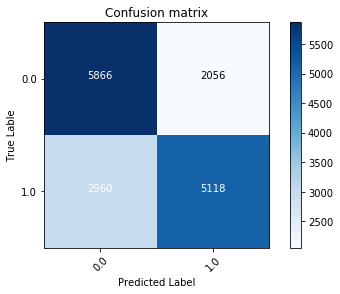

In [183]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test1, ypred_use))
cm = confusion_matrix(y_test1, ypred_use)
plot_confusion_matrix(cm, [0.0, 1.0])

In [169]:
#pickling random forest classifier for uselfulness


pickling_rf_use = open("rf_class_usef","wb")
pickle.dump(rf_use, pickling_rf_use)
pickling_rf_use.close()

In [170]:
pickle_rf_use = open("rf_class_usef","rb")
rf_use1 = pickle.load(pickle_rf_use)


In [65]:
#running a grid search for usefulness

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe_rf_useful = Pipeline([('rf', RandomForestClassifier(n_jobs=-1))])

parameters_useful = {
             'rf__n_estimators':[10,20,50,100],
             'rf__max_features':['auto',5,20]}

model_grid_useful = GridSearchCV(pipe_rf_useful,parameters_useful,n_jobs=-1, verbose=10)

In [66]:
model_grid_useful.fit(X_train13, y_train1)

/home/mubarakb/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  36 | elapsed:  1.6min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed:  2.3min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  13 out of  36 | elapsed:  2.6min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed:  2.8min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed:  3.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:  3.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  4.0min remaining:   57.2s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  4.3min remaining:   23.4s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.4min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rf__n_estimators': [10, 20, 50, 100], 'rf__max_features': ['auto', 5, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [68]:
model_grid_useful.best_params_

{'rf__max_features': 'auto', 'rf__n_estimators': 100}

In [159]:
#Making the big prediction of rating and usefullness

In [216]:
rev1=input()
use_pred_data= {'user_rev_count': [5], 'count_rev': [len(rev1.split(' '))],'rev_bus_rat_diff': [3.0]}
use_pred_df= pd.DataFrame(data= use_pred_data)
print('')

if len(rev1.split(' ')) < 10:
    print ('2 Stars')
    print('')
    print('Your Review WONT Be Helpful to others.')
    print('')
    print('If you wish to leave a better rating please describe your experience in more words')
else:
    for overview in [rev1]: 
        rev_string = []
        cleaned = nltk.regexp_tokenize(str(overview), pattern)
        tokens = [i.lower() for i in cleaned]
        tokens_stopped = [w for w in tokens if not w in stop_words]
        meta_stemmed = [stemmer.stem(word) for word in tokens_stopped]
        string = ' '.join(meta_stemmed)
        rev_string.append(string)
        tt = tfidf.transform(rev_string)
    # print(rev1)
        print ('')
        rev_pred = lin_reg_rating.predict(tt)

        for i in rev_pred:
            if i < 1.5:
                print ('1 Star')
            elif i < 2.5:
                print ('2 stars')
            elif i < 3.5:
                print ('3 stars')
            elif i < 4.5:
                print ('4 stars')
            else:
                print ('5 stars')
            print ("")
        
        #this is tfidf for the usefull datset unlike above it was for the rating datset 
        usett = tfidf_useful.transform(rev_string)    
        usett_features_tfidf = pd.DataFrame(usett.toarray(), columns=tfidf_useful.get_feature_names())
        pred_use_df= use_pred_df.join(usett_features_tfidf)
        pred_use_df1= scaler.transform(pred_use_df)
        use_pred= rf_use.predict(pred_use_df1)
        use_proba= rf_use.predict_proba(pred_use_df1)
#         print (use_pred)
#         print (rf_use.predict_proba(pred_use_df1))
        for a,b in use_proba:
            if b > 0.485:
                print ("Your review WILL be Helpful to others! ")
            else:
                print ("Your review WONT be Helpful to others! ")
                
                
                
                
                
                
                
                
                
                
                
                
                
                
                
                
                
                
                

                
                
                
  


it was good, enjoyed my meal but the service was slow. i'd come back if it were a wednesday early evening but no for the weekend


3 stars

Your review WONT be Helpful to others! 
